# Classification (clean up from classification notebook)

## Import libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

## Read files

In [2]:
df = pd.read_csv('../Data/dataset_others_class.csv')
df = df.rename(columns={'F_Close_pred_class':'Prediction'})
df

,Date,CADUSD=X_Open,CADUSD=X_Close,CADUSD=X_High,CADUSD=X_Low,CADUSD=X_Volume,CADUSD=X_Change,CADUSD=X_Gain,CADUSD=X_Loss,CADUSD=X_Avg_Gain,...,F_RSI,F_k_percent,F_r_percent,F_MACD,F_MACD_EMA,F_ROC,F_PVT,F_Bollinger_Upper,F_Bollinger_Lower,Prediction
0,2019-11-26 00:00:00+00:00,0.751665,0.751705,0.752842,0.750999,0.0,-0.000418,0.000000,0.000418,0.000289,...,62.087549,73.913071,-26.086929,0.006892,0.002249,-0.331855,2.394865e+06,9.188927,8.586074,1
1,2019-11-27 00:00:00+00:00,0.753597,0.753636,0.754205,0.752502,0.0,0.001932,0.001932,0.000000,0.000427,...,67.610216,89.583482,-10.416518,0.019164,0.005663,0.220269,2.768411e+06,9.183159,8.647842,0
2,2019-11-29 00:00:00+00:00,0.753125,0.753029,0.753211,0.751145,0.0,-0.000607,0.000000,0.000607,0.000427,...,62.910674,81.250149,-18.749851,0.025755,0.009711,0.221244,2.710846e+06,9.165730,8.712270,0
3,2019-12-02 00:00:00+00:00,0.752734,0.752791,0.753296,0.751569,0.0,-0.000238,0.000000,0.000238,0.000419,...,57.178300,70.833433,-29.166567,0.027163,0.013223,2.270145,2.505366e+06,9.172619,8.717381,0
4,2019-12-03 00:00:00+00:00,0.751552,0.751710,0.752899,0.750728,0.0,-0.001081,0.000000,0.001081,0.000419,...,45.657569,45.833433,-54.166567,0.019687,0.014522,1.137661,1.963927e+06,9.166840,8.712161,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,2024-10-22 00:00:00+00:00,0.722883,0.722883,0.723877,0.722684,0.0,-0.001776,0.000000,0.001776,0.000308,...,63.192190,91.764633,-8.235367,0.063288,0.007636,6.315788,6.779642e+07,11.195281,10.306719,0
1233,2024-10-23 00:00:00+00:00,0.723788,0.723788,0.723809,0.721433,0.0,0.000905,0.000905,0.000000,0.000245,...,59.825069,80.219848,-19.780152,0.071755,0.020460,4.635769,6.762839e+07,11.223237,10.297763,1
1234,2024-10-24 00:00:00+00:00,0.722716,0.722716,0.724008,0.721480,0.0,-0.001072,0.000000,0.001072,0.000245,...,67.105734,98.850548,-1.149452,0.091931,0.034754,7.149667,6.835647e+07,11.282170,10.320830,0
1235,2024-10-25 00:00:00+00:00,0.721850,0.721850,0.722648,0.720170,0.0,-0.000866,0.000000,0.000866,0.000245,...,56.038726,72.631549,-27.368451,0.093129,0.046429,4.237286,6.776479e+07,11.312438,10.329562,1


In [3]:
tickers = []
for col in df.columns:
    if '_RSI' in col:
        tickers.append(col.split('_')[0])

tickers.pop()
tickers

['CADUSD=X', 'GM', 'JCI', 'TM', 'TRYUSD=X', '^IXIC']

In [20]:
tickers = ['GM']

In [5]:
## Remove open, close, high, low, vol columns
open_cols = [col for col in df.columns if '_Open' in col]
close_cols = [col for col in df.columns if '_Close' in col]
high_cols = [col for col in df.columns if '_High' in col]
low_cols = [col for col in df.columns if '_Low' in col]
vol_cols = [col for col in df.columns if '_Volume' in col]

df = df.drop(columns=open_cols)
df = df.drop(columns=close_cols)
df = df.drop(columns=high_cols)
df = df.drop(columns=low_cols)
df = df.drop(columns=vol_cols)

#df

In [21]:
tickers

['GM']

## Extract F columns and one of other tickers

In [15]:
def extract_cols(df, ticker: str):
    F_cols = [col for col in df.columns if 'F_' in col]
    cols = F_cols.copy()

    for col in df.columns:
        if col == 'CADUSD=X_PVT' or col == 'TRYUSD=X_PVT':
            pass
        if ticker in col:
            cols.append(col)
            
    cols.append('Prediction')
    df_final = df[cols].copy()
    df_final = df_final.dropna()
            
    return df_final

In [17]:
df_test = extract_cols(df, tickers)
df_test

,F_Change,F_Gain,F_Loss,F_Avg_Gain,F_Avg_Loss,F_SMA,F_EMA,F_change_in_price,F_RSI,F_k_percent,...,GM_change_in_price,GM_RSI,GM_k_percent,GM_r_percent,GM_MACD,GM_MACD_EMA,GM_ROC,GM_PVT,GM_Bollinger_Upper,Prediction
0,0.010000,0.010000,0.000000,0.046429,0.040000,8.8875,8.851336,0.010000,62.087549,73.913071,...,0.099998,39.869583,30.205950,-69.794050,-0.456238,-0.330635,-7.137312,-8.069465e+05,39.749163,1
1,0.090000,0.090000,0.000000,0.052857,0.037857,8.9155,8.875019,0.090000,67.610216,89.583482,...,0.230000,44.605300,35.469099,-64.530901,-0.422054,-0.349089,-6.663228,-7.695503e+05,39.675403,0
2,-0.040000,0.000000,0.040000,0.042143,0.040714,8.9390,8.892636,-0.040000,62.910674,81.250149,...,-0.139999,42.267307,32.265451,-67.734549,-0.399949,-0.359336,-6.711584,-7.847627e+05,39.661676,0
3,-0.050000,0.000000,0.050000,0.039286,0.044286,8.9450,8.903813,-0.050000,57.178300,70.833433,...,-0.119999,40.184202,29.519479,-70.480521,-0.386217,-0.364745,-3.522446,-8.073692e+05,39.565133,0
4,-0.120000,0.000000,0.120000,0.039286,0.050000,8.9395,8.902498,-0.120000,45.657569,45.833433,...,-0.350002,34.467362,24.671871,-75.328129,-0.395055,-0.370835,-3.451088,-8.874659e+05,39.396739,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,0.230000,0.230000,0.000000,0.074286,0.048571,10.7510,10.840467,0.230000,63.192190,91.764633,...,4.799999,84.257644,95.553352,-4.446648,1.032789,0.473164,19.453090,3.677383e+07,51.759160,0
1233,-0.049999,0.000000,0.049999,0.074286,0.032857,10.7605,10.861375,-0.049999,59.825069,80.219848,...,-0.810001,75.847228,87.462973,-12.537027,1.272034,0.632938,15.849382,3.653097e+07,52.651844,1
1234,0.179999,0.179999,0.000000,0.087143,0.030714,10.8015,10.897435,0.179999,67.105734,98.850548,...,-0.199997,73.749952,82.045476,-17.954524,1.429027,0.792156,14.583793,3.648637e+07,53.404043,0
1235,-0.170000,0.000000,0.170000,0.078571,0.042857,10.8210,10.913869,-0.170000,56.038726,72.631549,...,-0.650002,66.821000,74.159916,-25.840084,1.483890,0.930502,8.637595,3.638225e+07,53.911479,1


## Plot histogram for each ticker

GM


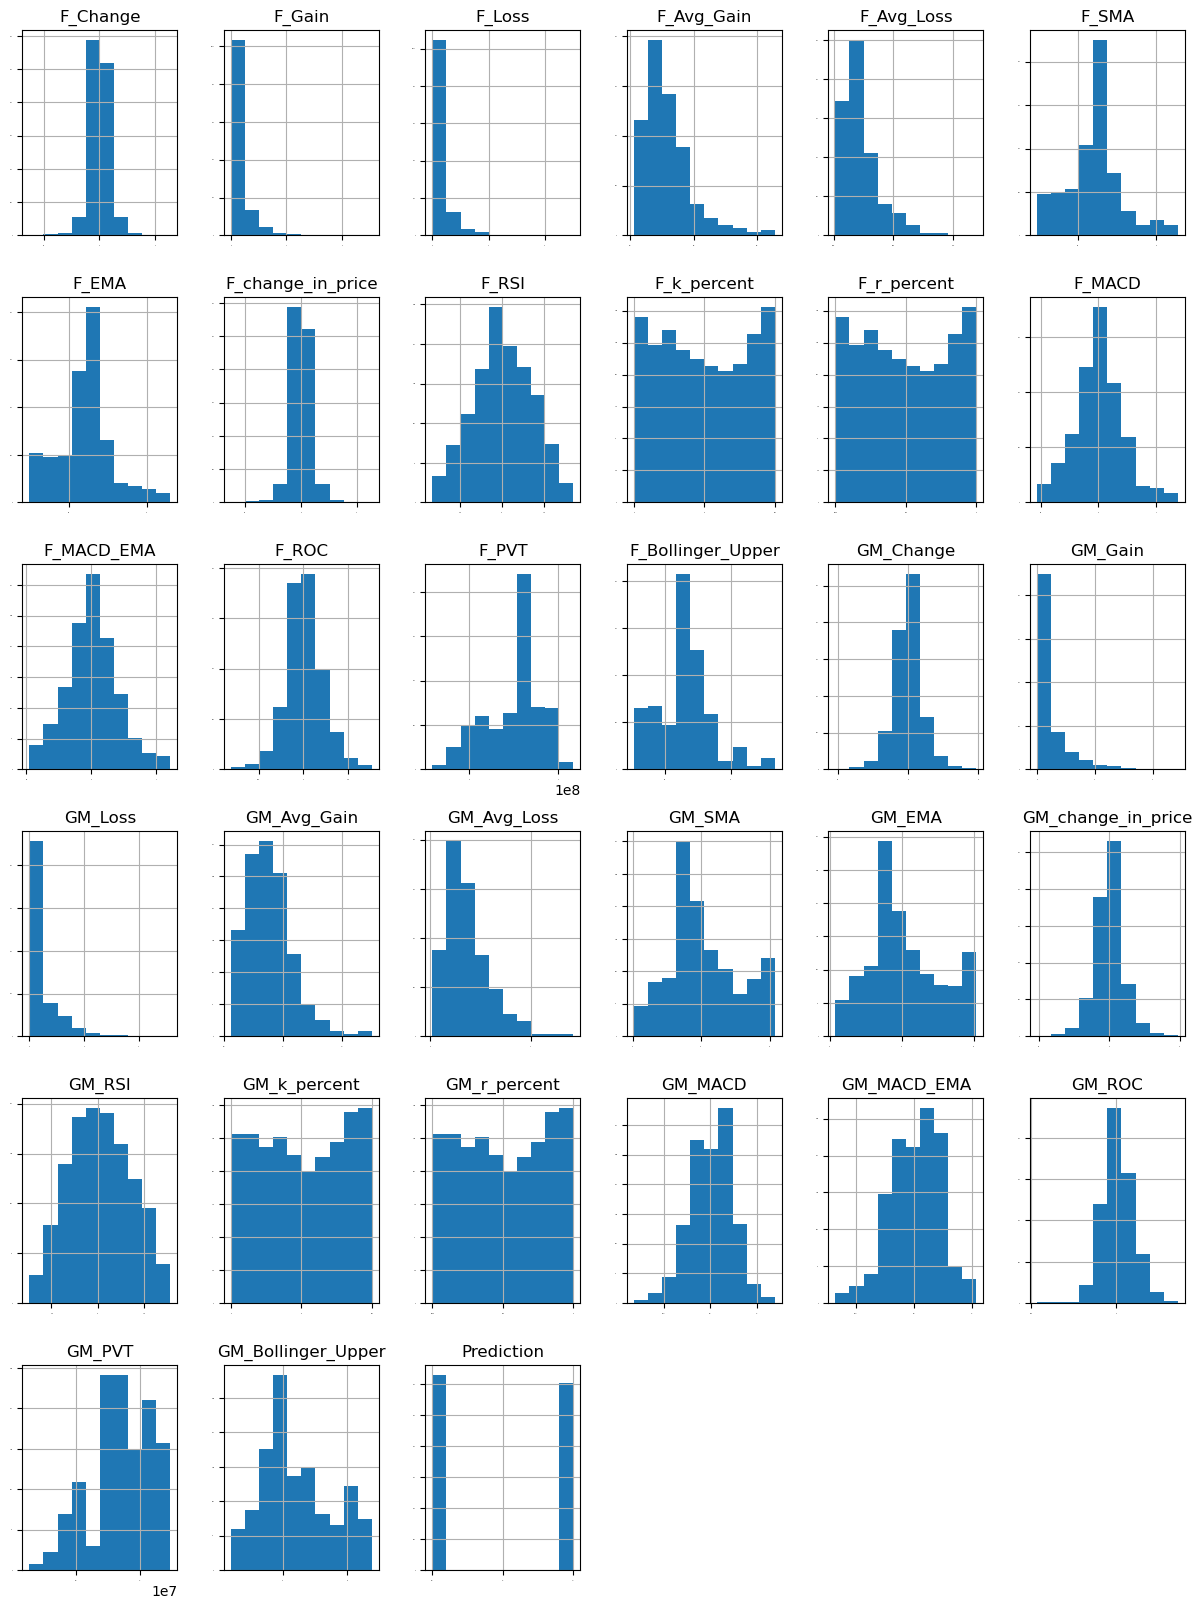

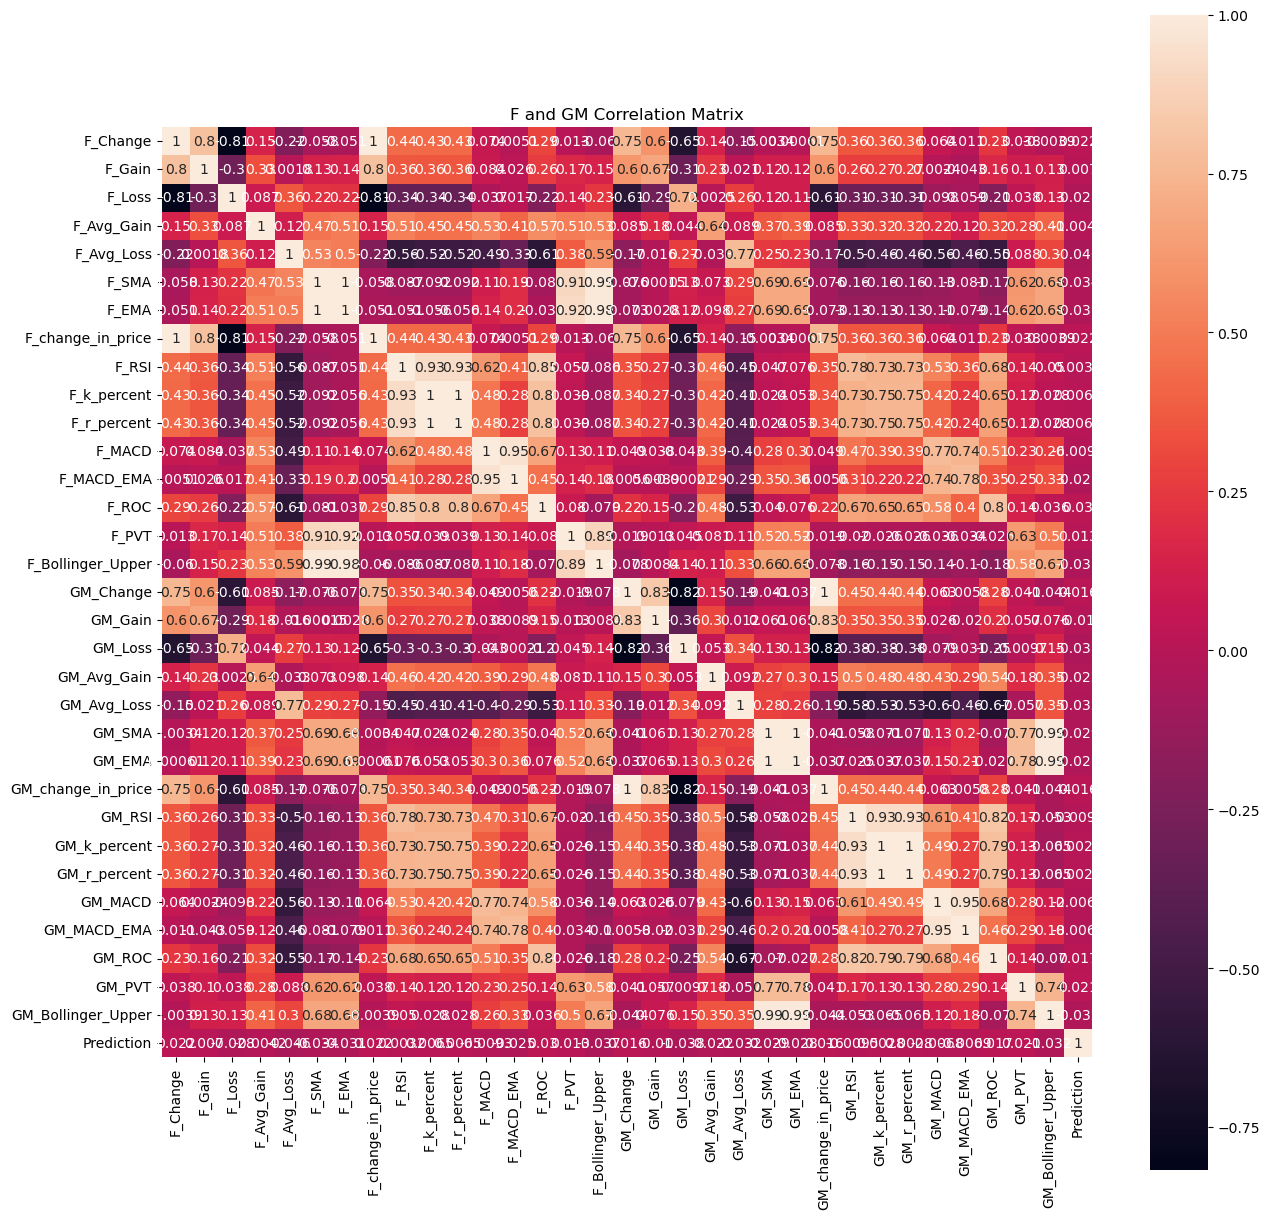

In [22]:
for t in tickers:
    print(t)
    df1 = extract_cols(df, t)
    df1.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15,20))
    plt.show()

    correlation = df1.corr()
    plt.figure(figsize=(15,15))
    plt.title('F and ' + t + ' Correlation Matrix')
    sns.heatmap(correlation, vmax=1, square=True, annot=True)
    plt.show()

## Split train-test sets

In [25]:
def split_1(df, ticker: str, test_size = 0.20):
    '''F_cols = [col for col in df.columns if 'F_' in col]
    cols = F_cols.copy()

    for col in df.columns:
        if ticker in col and 'CADUSD=X_PVT' not in col and 'TRYUSD=PVT' not in col:
            cols.append(col)  
        
    cols.append('Prediction')
    df1 = df[cols].copy()
    df1 = df1.dropna()
    '''
    df1 = extract_cols(df, ticker)
    y = df1['Prediction']
    X = df1.drop(['Prediction'], axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify=y, random_state = 132)

    return X_train, X_test, y_train, y_test

## Build random Forest Grid Search

In [9]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
n_estimators = [20, 50, 100, 500, 1000, 2000]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth = [2, 4, 10, 20, 50, 100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
#criterion = ['gini', 'entropy', 'log_loss']

# Create parameter grids
param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap#,
    #'criterion': criterion
}

In [10]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy*100))
    
    return accuracy*100

In [11]:
def best_grid_search(rf, X_train, X_test, y_train, y_test):
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    best_grid = grid_search.best_estimator_

    # Base model
    base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
    base_model.fit(X_train, y_train)
    base_accuracy = evaluate(base_model, X_test, y_test)
    print('Base model accuracy:', base_accuracy) 
    
    # best grid
    best_grid = grid_search.best_estimator_
    best_accuracy = evaluate(best_grid, X_test, y_test)
    print('Best Grid search model accuracy:', best_accuracy) 

    improvement = 100 * (best_accuracy - base_accuracy) / base_accuracy
    
    
    print('Improvement of {:0.2f}%.'.format(improvement))

    return best_grid, best_accuracy, improvement

    #feature_names = [col for col in X_train.columns]
    #importances = best_grid.feature_importances_

    #forest_importances = pd.Series(importances, index=feature_names)
      
    #fig, ax = plt.subplots(figsize=(12, 5))
    #forest_importances.plot.bar(ax=ax)
    #ax.set_title("Feature importances using MDI")
    #ax.set_ylabel("Mean decrease in impurity")
    #plt.show()

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Model Performance
Accuracy = 51.21%.
Base model accuracy: 51.20967741935484
Model Performance
Accuracy = 50.00%.
Best Grid search model accuracy: 50.0
Improvement of -2.36%.


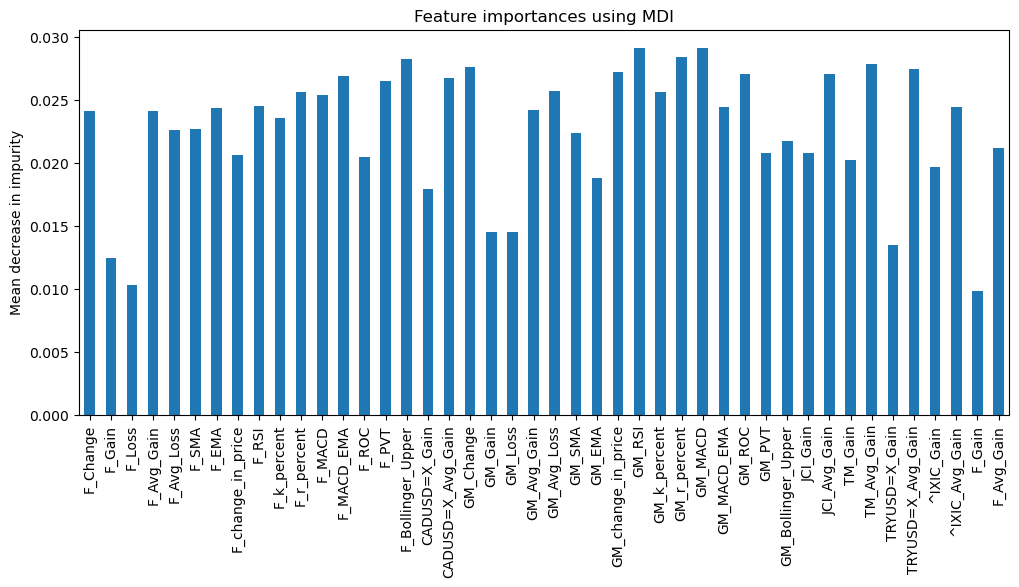

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
Model Performance
Accuracy = 54.84%.
Base model accuracy: 54.83870967741935
Model Performance
Accuracy = 54.84%.
Best Grid search model accuracy: 54.83870967741935
Improvement of 0.00%.


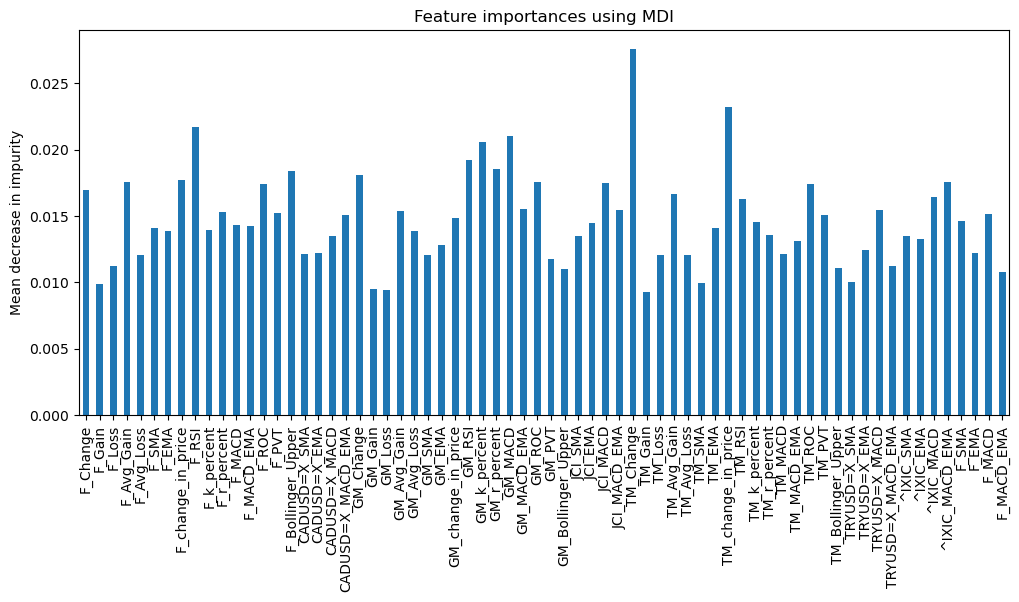

In [12]:
for t in tickers:
    
    df1 = extract_cols(df, t)
    X_train, X_test, y_train, y_test = split_1(df, t, test_size = 0.20)

    # Create a random forest model
    rf = RandomForestClassifier()
    
    best_grid, best_accuracy, improvement = best_grid_search(rf, X_train, X_test, y_train, y_test)
    
    feature_names = [col for col in X_train.columns]
    importances = best_grid.feature_importances_

    forest_importances = pd.Series(importances, index=feature_names)
      
    fig, ax = plt.subplots(figsize=(12, 5))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    plt.show()